Notebook created by me by following along with JAX tutorials by Aleksa Gordic

In [1]:
from jax import grad, jit, vmap, pmap, lax, make_jaxpr, random, device_put
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

# JAX NumPy and Random Numbers

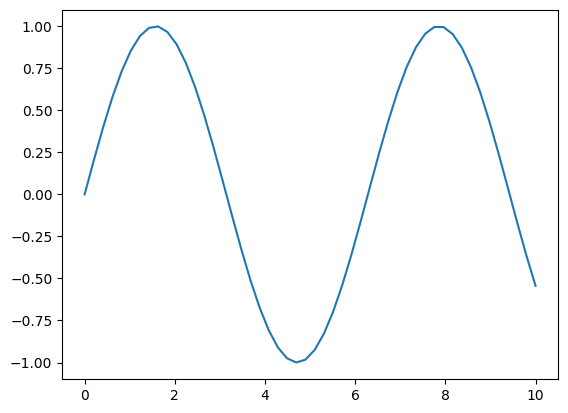

In [3]:
# jnp very similar to numpy
x = jnp.linspace(0, 10)
y = jnp.sin(x)

plt.plot(x, y)

In [7]:
# Immutable arrays in JAX

arr = jnp.array([1,2,3])
print(arr)
arr = arr.at[1].set(0) # Use this to mutate, returns copy (sometimes?)
print(arr)

[1 2 3]
[1 0 3]


In [10]:
# Random numbers in JAX have to be passed an explicit key

key = random.PRNGKey(42)
rand_num = random.uniform(key, (1,))
print(rand_num)

[0.42672753]


# JIT

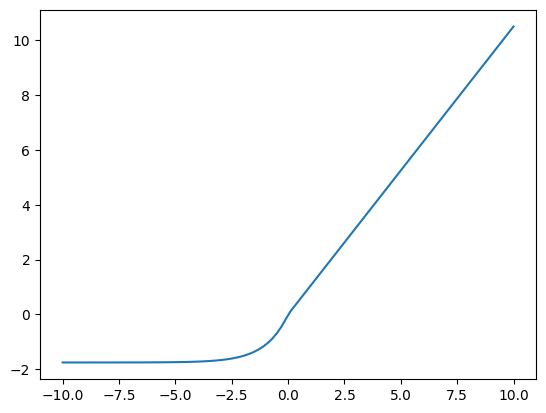

30.5 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
3.54 µs ± 25.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
# JIT compiles into XLA and caches it

def visualize(fn, l=-10, r=10, n=100):
    x = jnp.linspace(l, r, n)
    y = fn(x)
    plt.plot(x, y)
    plt.show()

# Some function from R^n -> R
def selu(x, alpha=1.67, l=1.05):
    return l * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

visualize(selu)

selu_jit = jit(selu)
data = random.normal(key, (100,))

%timeit selu(data).block_until_ready()
%timeit selu_jit(data).block_until_ready()

### JIT Failures:
- Array shapes must be static
- Cannot condition upon value (if you do, you can use static_argnums)
- Functions inside functions may need to be replaced by numpy functions if they can't handle a Traced input

In [16]:
# Conditioning upon some value
def condition(x, val):
    print(f'Tracing')
    return -x if val else x

jit_condition = jit(condition, static_argnums=(1,))
print(jit_condition(random.uniform(key, (5,)), True))
print(jit_condition(random.uniform(key, (5,)), True))
print(jit_condition(random.uniform(key, (5,)), False))

Tracing
[-0.7298188  -0.8691938  -0.19643795 -0.20818567 -0.18662417]
[-0.7298188  -0.8691938  -0.19643795 -0.20818567 -0.18662417]
Tracing
[0.7298188  0.8691938  0.19643795 0.20818567 0.18662417]


# Grad

In [21]:
from jax import jacfwd, jacrev

# Automatic diff

def sum_squares(x):
    return jnp.sum(x ** 2)

x = jnp.arange(3.)
grad_sum_squares = grad(sum_squares)
print(grad_sum_squares(x))

def vector_valued(x, y):
    return x ** 2 + y ** 2

print(jacfwd(vector_valued, argnums=(0, 1))(1., 2.))

[0. 2. 4.]
(Array(2., dtype=float32, weak_type=True), Array(4., dtype=float32, weak_type=True))


# vmap

In [31]:
# Auto batching

def dot_prod(W, x):
    return jnp.dot(W, x)

# The first argument has no batch axis (None), the second one uses the first dim as batch -> 20 10 x 10 15 -> 20 15 
# out_axes=1 moves batch axis to dim 1
vmap(dot_prod, in_axes=(None, 0), out_axes=1)(random.uniform(key, (15, 10)), random.uniform(key, (20,10))).shape

(15, 20)

# Gotchas